In [1]:
# Clear variables
#%reset -f

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.dates as mdates

import matplotlib.gridspec as gridspec
from datetime import datetime
#A temperature_nsw = pd.read_csv('C:/Users/aland/Downloads/Data/Data/temperature_nsw.csv', sep = ',', header =0 )
#Atotaldemand_nsw = pd.read_csv('C:/Users/aland/Downloads/Data/Data/totaldemand_nsw.csv', sep = ',', header = 0)
#A forecastdemand_nsw = pd.read_csv('C:/Users/aland/Downloads/Data/Data/forecastdemand_nsw.csv', sep = ',', header = 0, usecols=[0, 1, 2, 3])
#A population_nsw = pd.read_csv('C:/Users/aland/Downloads/Data/Data/nsw_population.csv', sep = ',', header = 0)

##temperature_nsw = pd.read_csv('C:/Users/Darryn.Marjoram/Darryn UNSW/temperature_nsw.csv', sep = ',', header =0 )
totaldemand_nsw = pd.read_csv('C:/Users/Darryn.Marjoram/Darryn UNSW/totaldemand_nsw.csv', sep = ',', header =0 )
forecastdemand_nsw = pd.read_csv('C:/Users/Darryn.Marjoram/Darryn UNSW/forecastdemand_nsw.csv', sep = ',', header =0 )
population_nsw = pd.read_csv('C:/Users/Darryn.Marjoram/Darryn UNSW/nsw_population.csv', sep = ',', header =0 )

#J temperature_nsw = pd.read_csv('A:UNSW/project/project-main/project-main/data/NSW/temperature_nsw.csv/temperature_nsw.csv', sep = ',', header =0 )
#J totaldemand_nsw = pd.read_csv('A:UNSW/project/project-main/project-main/data/NSW/totaldemand_nsw.csv/totaldemand_nsw.csv', sep = ',', header = 0)
#J forecastdemand_nsw = pd.read_csv('A:UNSW/project/project-main/project-main/data/forecastdemand_nsw.csv/forecastdemand_nsw.csv', sep = ',', header = 0)
#J population_nsw = pd.read_csv('A:UNSW/project/project-main/project-main/data/nsw_population.csv', sep = ',', header =0 )


In [2]:
# Convert 'DATETIME' from object to datetime format
totaldemand_nsw = totaldemand_nsw.reset_index()
##print(totaldemand_nsw.head())
#totaldemand_nsw['DATETIME'] = pd.to_datetime(totaldemand_nsw['DATETIME'], dayfirst=True)
totaldemand_nsw["DATETIME"] = pd.to_datetime(totaldemand_nsw["DATETIME"], dayfirst=True)
totaldemand_nsw = totaldemand_nsw.set_index("DATETIME")

# Extract year, month, day, and time from 'DATETIME' column
totaldemand_nsw["year"] = totaldemand_nsw.index.year
totaldemand_nsw["month"] = totaldemand_nsw.index.month
totaldemand_nsw["day"] = totaldemand_nsw.index.day
totaldemand_nsw["time"] = totaldemand_nsw.index.time

totaldemand_nsw = totaldemand_nsw[totaldemand_nsw['year'] <= 2021]
# Display the first few rows to verify
##print(totaldemand_nsw.head())

forecastdemand_nsw = forecastdemand_nsw.reset_index()

##print(totaldemand_nsw.head())
forecastdemand_nsw["DATETIME"] = pd.to_datetime(forecastdemand_nsw["DATETIME"], dayfirst=True)
forecastdemand_nsw = forecastdemand_nsw.set_index("DATETIME")

# Extract year, month, day, and time from 'DATETIME' column
forecastdemand_nsw["year"] = forecastdemand_nsw.index.year
forecastdemand_nsw["month"] = forecastdemand_nsw.index.month
forecastdemand_nsw["day"] = forecastdemand_nsw.index.day
forecastdemand_nsw["time"] = forecastdemand_nsw.index.time

forecastdemand_nsw = forecastdemand_nsw[forecastdemand_nsw['year'] <= 2021]
##print(forecastdemand_nsw.tail())

In [3]:
totaldemand_nsw.drop(['REGIONID'],axis=1,inplace= True)
#print(totaldemand_nsw.head())

# Exploratory Data Analysis, adopted for LSTM

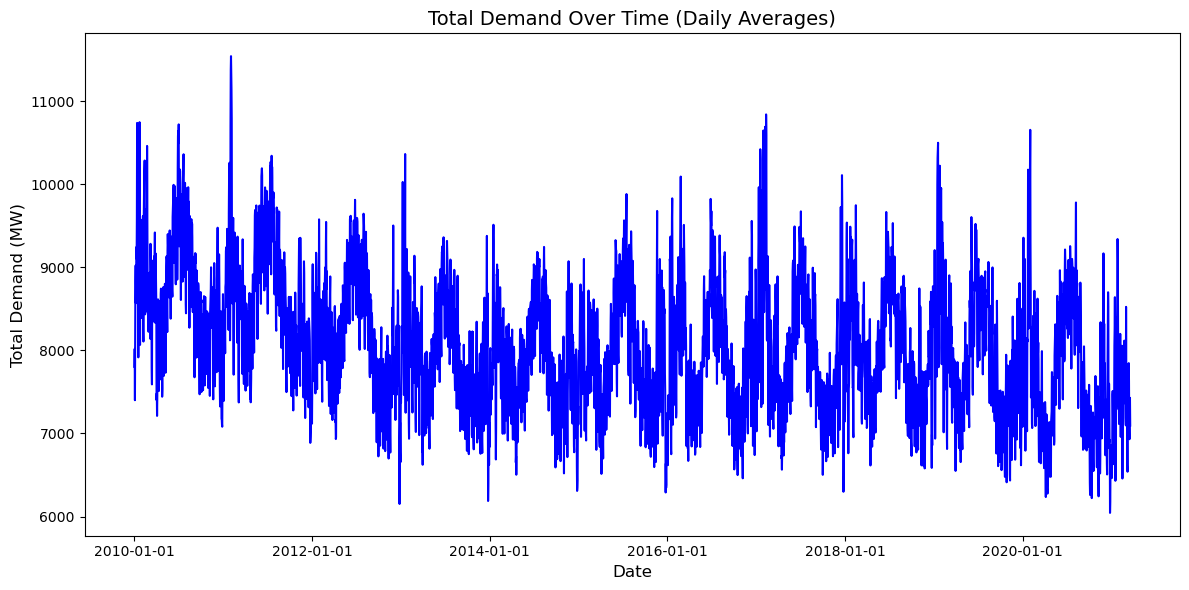

In [4]:
#Drop non-numeric columns 
totaldemand_nsw_cleaned = totaldemand_nsw.drop(columns=['year', 'month', 'day', 'time'])

# Step 2: Resample the data for daily mean values based on the 'TOTALDEMAND' column
#daily_totaldemand_nsw = totaldemand_nsw_cleaned.resample('D').mean()
daily_totaldemand_nsw = totaldemand_nsw_cleaned.resample('D').mean(numeric_only=True)

# Step 3: Plot the data
plt.figure(figsize=(12, 6))
plt.plot(daily_totaldemand_nsw.index, daily_totaldemand_nsw['TOTALDEMAND'], linestyle='-', color='blue')

# Set plot title and labels
plt.title('Total Demand Over Time (Daily Averages)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Demand (MW)', fontsize=12)

# Format the x-axis to show years with major ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

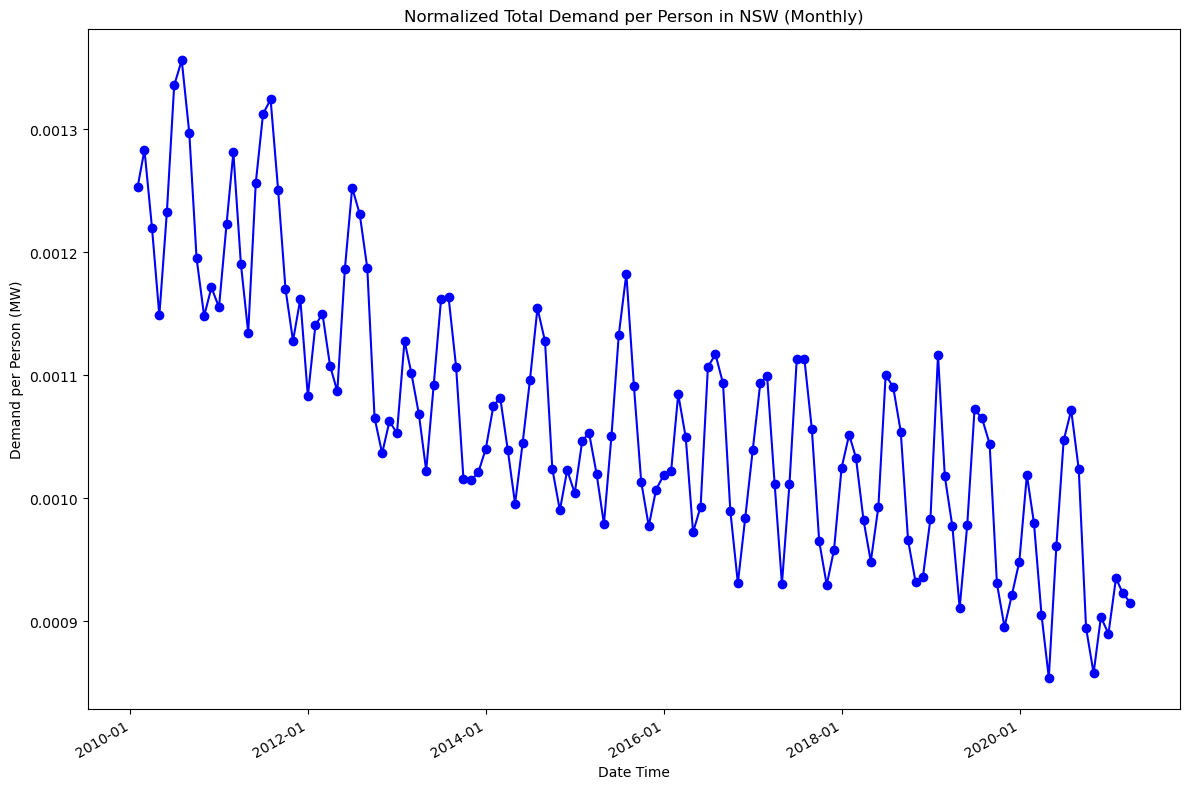

In [5]:
# Ensure the population data has the correct columns
population_nsw = population_nsw.rename(columns={'Year': 'year', 'TotalPopulation': 'TotalPopulation'})

#Dropping columns
totaldemand_nsw_cleaned = totaldemand_nsw.select_dtypes(include=[float, int])

# Resample the data for monthly mean values
monthly_totaldemand_nsw = totaldemand_nsw_cleaned.resample('M').mean()

# Extract year and month from index
monthly_totaldemand_nsw['year'] = monthly_totaldemand_nsw.index.year
monthly_totaldemand_nsw['month'] = monthly_totaldemand_nsw.index.month

# Aggregate population data to monthly level
monthly_population_nsw = population_nsw.set_index('year').reindex(monthly_totaldemand_nsw['year'].unique()).ffill()

# Merge monthly total demand with monthly population data
monthly_data = pd.merge(monthly_totaldemand_nsw, monthly_population_nsw, left_on='year', right_index=True)


# Normalize total demand by population
monthly_data['demand_per_person'] = monthly_data['TOTALDEMAND'] / monthly_data['TotalPopulation']

# Normalize total Rooftol Capacity by population
##monthly_data_solar['demand_per_person'] = monthly_data['TOTALDEMAND'] / monthly_data['TotalPopulation']

# Plot the normalized demand
plt.figure(figsize=(12, 8))
plt.plot(monthly_data.index, monthly_data['demand_per_person'], linestyle='-', marker='o', color='b')

plt.title('Normalized Total Demand per Person in NSW (Monthly)')
plt.xlabel('Date Time')
plt.ylabel('Demand per Person (MW)')

# Format the x-axis to show years and months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

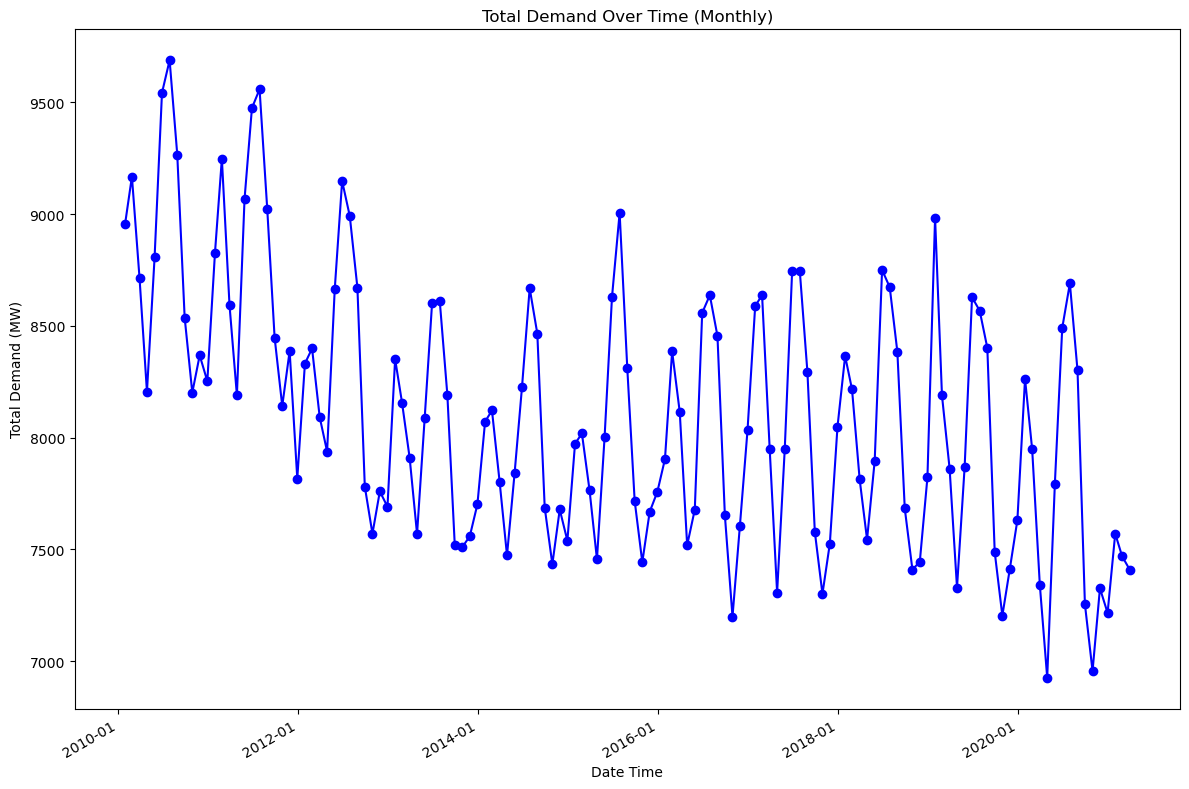

In [6]:
#Drop non-numeric columns 
totaldemand_nsw_cleaned = totaldemand_nsw.drop(columns=['year', 'month', 'day', 'time'])

# Step 2: Resample the data for daily mean values based on the 'TOTALDEMAND' column
daily_totaldemand_nsw = totaldemand_nsw_cleaned.resample('D').mean()


#Dropping columns
totaldemand_nsw_cleaned = totaldemand_nsw.select_dtypes(include=[float, int])

# Resample the data for monthly mean values
monthly_totaldemand_nsw = totaldemand_nsw_cleaned.resample('M').mean()

# Extract year and month from index
monthly_totaldemand_nsw['year'] = monthly_totaldemand_nsw.index.year
monthly_totaldemand_nsw['month'] = monthly_totaldemand_nsw.index.month

##### above added by DjM ######

monthly_totaldemand_nsw = totaldemand_nsw_cleaned.resample('M').mean()

# Plot the monthly total demand
plt.figure(figsize=(12, 8))
plt.plot(monthly_totaldemand_nsw.index, monthly_totaldemand_nsw['TOTALDEMAND'], linestyle='-', marker='o', color='b')

# Set plot title and labels
plt.title('Total Demand Over Time (Monthly)')
plt.xlabel('Date Time')
plt.ylabel('Total Demand (MW)')

# Format the x-axis to show years and months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

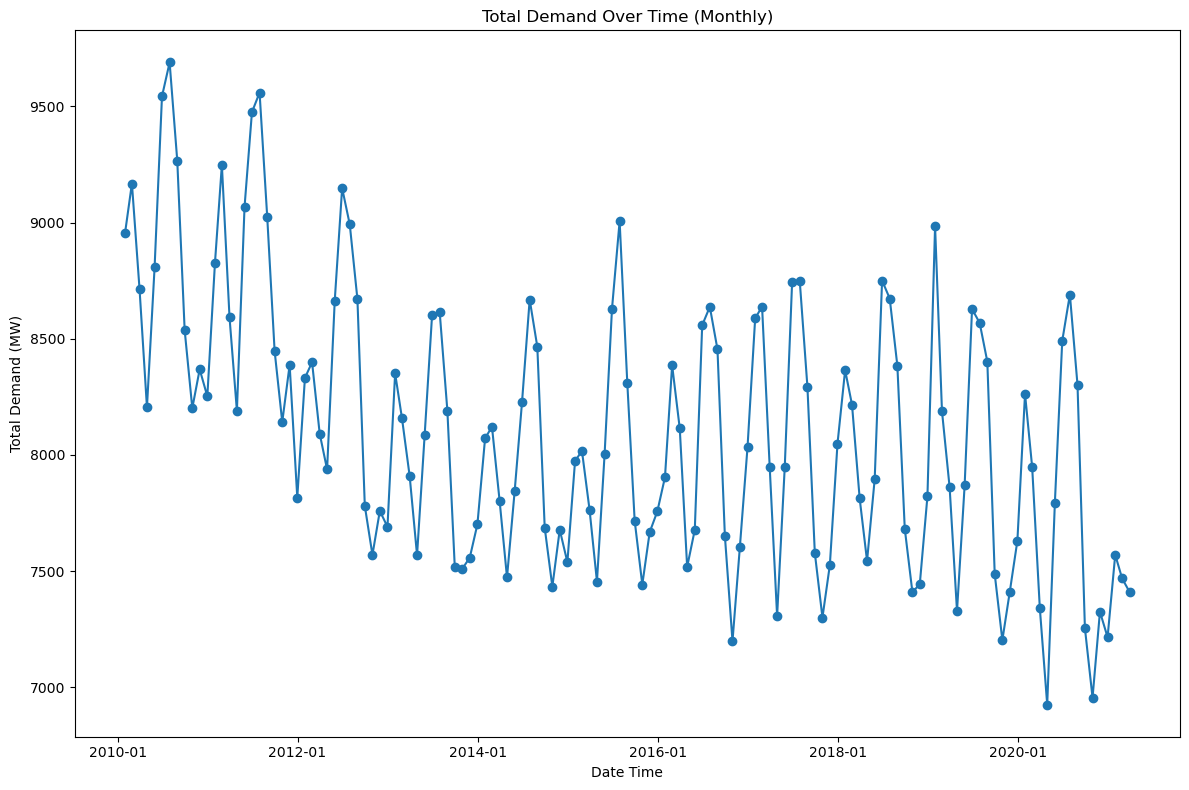

In [7]:
plt.figure(figsize=(12, 8))
# Plot the data
plt.plot(monthly_totaldemand_nsw.index, monthly_totaldemand_nsw['TOTALDEMAND'], linestyle='-', marker='o')

# Set plot title and labels
plt.title('Total Demand Over Time (Monthly)')
plt.xlabel('Date Time')
plt.ylabel('Total Demand (MW)')

# Format the x-axis to show years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

### Total Solar Capacity 2011-2021
The graph above shows the total solar capacity (Mega Watts) in NSW from 2011 to 2021. 
From 2011 to 2016, the growth in solar output remained relatively stable, fluctuating slightly between ##3 CHECK THEse NUMBERS### 200,000 and 250,000 Kw, with minimal overall change. Starting from 2017, there was a sharp increase in solar output. This rapid growth accelerated further after 2018, peaking in 2021 at over 1,000,000 Kw. This steep rise reflects increased adoption of solar power, likely driven by advancements in technology, more government incentives, and a greater public push toward renewable energy sources.

This data highlights a major shift in solar energy adoption, with the sharp incline from 2017 onward illustrating the accelerating expansion of solar power in NSW.


In [8]:
#Solar Data, shows number os systems installed by postcode
solar_int_df = pd.read_csv('C:/Users/Darryn.Marjoram/Darryn UNSW/sgu-solar-installations-2011-to-present.csv', sep=',', header=3, dtype={'Small Unit Installation Postcode': str})
## shows system capacity in kW by postcode
solar_cap_df = pd.read_csv('C:/Users/Darryn.Marjoram/Darryn UNSW/sgu-solar-capacity-2011-to-present.csv', sep=',', header=0, dtype={'Small Unit Installation Postcode': str})

#### CLEANING ####
# Strip spaces and handle NaN values
solar_int_df['Small Unit Installation Postcode'] = solar_int_df['Small Unit Installation Postcode'].str.strip().fillna('')
solar_cap_df['Small Unit Installation Postcode'] = solar_cap_df['Small Unit Installation Postcode'].str.strip().fillna('')

## remove Unnamed columns from the Installations data frame
solar_int_df = solar_int_df.loc[:, ~solar_int_df.columns.str.contains('^Unnamed')]

# Data Cleaning remove unwanted string
solar_int_df.columns = solar_int_df.columns.str.replace(' - Installations Quantity', '', regex=False)
solar_cap_df.columns = solar_cap_df.columns.str.replace(' - SGU Rated Output In kW', '', regex=False)
## force the postcode to be string
solar_int_df['Small Unit Installation Postcode'] = solar_int_df['Small Unit Installation Postcode'].astype(str)
# Print unique postcodes before filtering
##print("Unique postcodes before filtering:", solar_int_df['Small Unit Installation Postcode'].unique())

solar_int_df = solar_int_df.fillna(0)
##print(solar_int_df)

#Filter to NSW
##solar_df_int_nsw = solar_int_df.loc[
##    solar_int_df['Small Unit Installation Postcode'].str.startswith('2')]
# Filtering to NSW postcodes within the specified ranges
solar_df_int_nsw = solar_int_df.loc[
    solar_int_df['Small Unit Installation Postcode'].astype(str).str.match(
        r'^(1[0-9]{3}|2[0-5][0-9]{2}|261[0-9]|28[0-9]{2}|292[1-9]|29[2-9][0-9])$'
    )]

solar_df_int_nsw = solar_df_int_nsw.loc[solar_df_int_nsw['Small Unit Installation Postcode'].str.len() == 4]
##print(solar_df_int_nsw)
# Filter to NSW postcodes within the specified ranges
solar_df_cap_nsw = solar_cap_df.loc[
    solar_cap_df['Small Unit Installation Postcode'].astype(str).str.match(
        r'^(1[0-9]{3}|2[0-5][0-9]{2}|261[0-9]|28[0-9]{2}|292[1-9]|29[2-9][0-9])$'
    )]
solar_df_cap_nsw = solar_df_cap_nsw.loc[solar_df_cap_nsw['Small Unit Installation Postcode'].str.len() == 4]

solar_df_int_cleaned = solar_df_int_nsw.drop(columns=['Small Unit Installation Postcode'])
solar_cap_clean = solar_cap_df.drop(columns=['Small Unit Installation Postcode'])

solar_df_int_month = solar_df_int_cleaned.sum(axis=0)
##print(solar_df_int_month)
solar_cap_month = solar_cap_clean.sum(axis=0)
##print(solar_cap_month)

solar_summary_int_nsw = pd.DataFrame({
    'Month': solar_df_int_month.index,
    'Installations': solar_df_int_month.values
})

solar_summary_cap_nsw = pd.DataFrame({
    'MonthYear': solar_cap_month.index,
    'Capacity kW': solar_cap_month.values
})
##print(solar_summary_int_nsw)
##print(solar_summary_cap_nsw)

     MonthYear  Capacity kW  year  month
0   2011-01-01    58108.745  2011      1
1   2011-02-01    64580.979  2011      2
2   2011-03-01    80117.775  2011      3
3   2011-04-01    75990.197  2011      4
4   2011-05-01   115957.991  2011      5
..         ...          ...   ...    ...
158 2024-03-01   240267.350  2024      3
159 2024-04-01   236669.022  2024      4
160 2024-05-01   254178.962  2024      5
161 2024-06-01   206615.020  2024      6
162 2024-07-01   153542.419  2024      7

[163 rows x 4 columns]
     MonthYear  Capacity kW  year  month
0   2011-01-01    58108.745  2011      1
1   2011-02-01    64580.979  2011      2
2   2011-03-01    80117.775  2011      3
3   2011-04-01    75990.197  2011      4
4   2011-05-01   115957.991  2011      5
..         ...          ...   ...    ...
115 2020-08-01   226446.610  2020      8
116 2020-09-01   255261.121  2020      9
117 2020-10-01   266883.461  2020     10
118 2020-11-01   318272.327  2020     11
119 2020-12-01   334485.135  2020

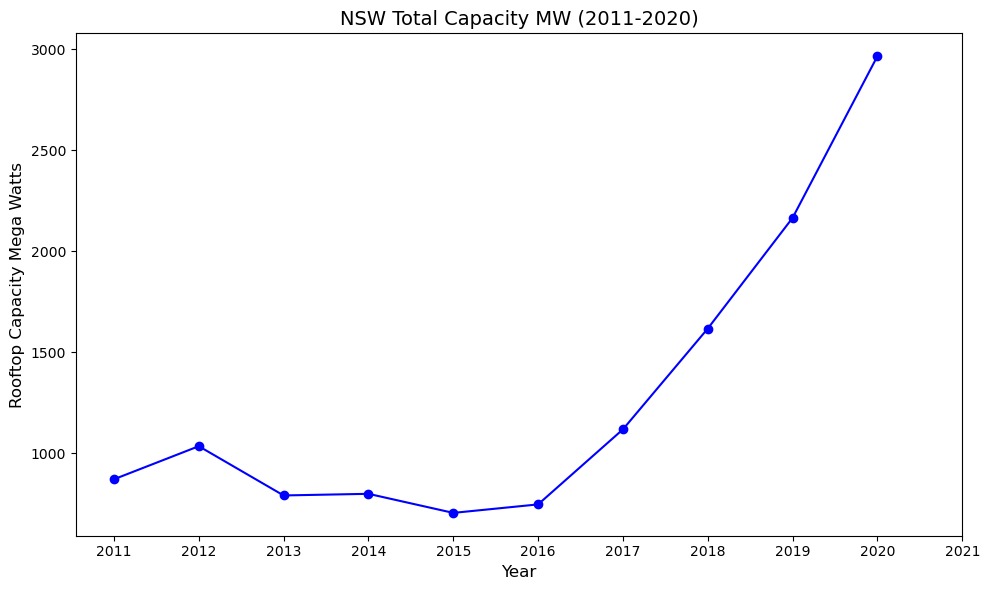

In [9]:
# Convert the 'Month' column to a datetime format for better plotting

# add 'Year' column based on 'Month'
solar_summary_int_nsw['Month'] = pd.to_datetime(solar_summary_int_nsw['Month'], format='%b %Y', errors='coerce')
solar_summary_cap_nsw['MonthYear'] = pd.to_datetime(solar_summary_cap_nsw['MonthYear'], format='%b %Y', errors='coerce')

solar_summary_cap_nsw['year'] = solar_summary_cap_nsw['MonthYear'].dt.year
solar_summary_cap_nsw['month'] = solar_summary_cap_nsw['MonthYear'].dt.month
solar_summary_int_nsw['Year'] = solar_summary_int_nsw['Month'].dt.year
print(solar_summary_cap_nsw)
##print(solar_summary_int_nsw)

# Filter data for the years 2011 to 2021
solar_summary_int_nsw_filtered = solar_summary_int_nsw[solar_summary_int_nsw['Year'].between(2011, 2020)] #2021)]
##solar_summary_cap_nsw_filtered = solar_summary_cap_nsw[solar_summary_cap_nsw['year'].between(2011, 2021)]
solar_summary_cap_nsw_filtered = solar_summary_cap_nsw[solar_summary_cap_nsw['year'].between(2011, 2020)]

##print(solar_summary_int_nsw_filtered)
print(solar_summary_cap_nsw_filtered)
solar_summary_int_yearly = solar_summary_int_nsw_filtered.groupby('Year')['Installations'].sum().reset_index()
solar_summary_cap_yearly = solar_summary_cap_nsw_filtered.groupby('year')['Capacity kW'].sum().reset_index()
##print(solar_summary_cap_yearly)
##print(solar_summary_int_yearly)

if 'Capacity kW' in solar_summary_cap_yearly.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(solar_summary_cap_yearly['year'], solar_summary_cap_yearly['Capacity kW']/1000, marker='o', linestyle='-', color='b')

    # Adding title and labels
plt.title('NSW Total Capacity MW (2011-2020)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Rooftop Capacity Mega Watts', fontsize=12)
plt.xticks(ticks=range(2011, 2022))

# Display the graph
plt.tight_layout()
plt.show()

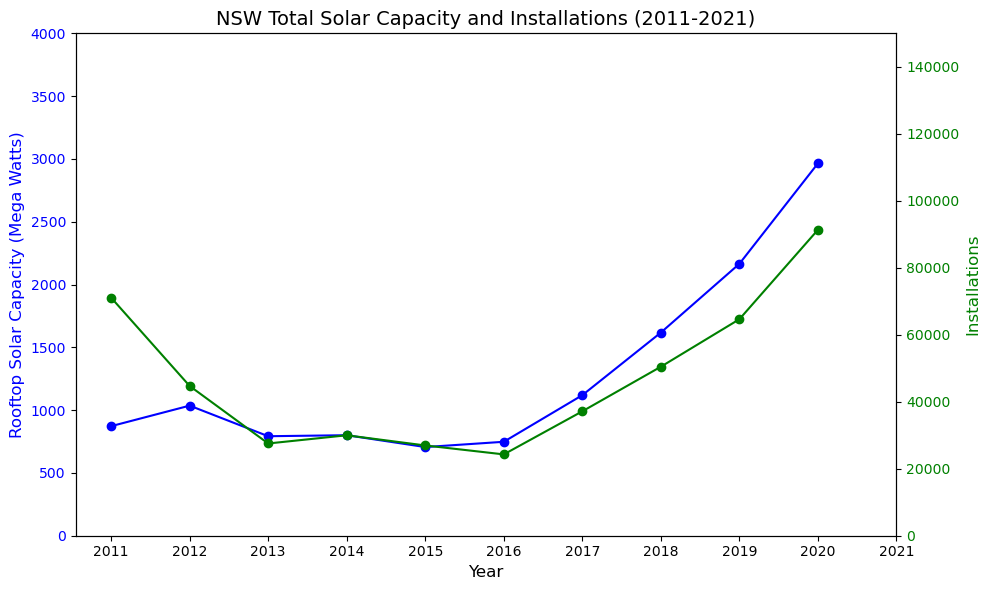

In [10]:
# Plot the multigraph with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot solar output on the left y-axis (blue)
ax1.plot(solar_summary_cap_yearly['year'], solar_summary_cap_yearly['Capacity kW']/1000, 
         marker='o', linestyle='-', color='b', label='Solar Capacity (Mega Watts)')
ax1.set_xlabel('Year', fontsize=12)

ax1.set_ylabel('Rooftop Solar Capacity (Mega Watts)', fontsize=12, color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Set the y-axis limits for solar output 
ax1.set_ylim(0, 4000)

#y-axis for installations (green)
ax2 = ax1.twinx()
ax2.plot(solar_summary_int_yearly['Year'], solar_summary_int_yearly['Installations'], 
         marker='o', linestyle='-', color='g', label='Installations')
ax2.set_ylabel('Installations', fontsize=12, color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Set the y-axis limits for installations
ax2.set_ylim(0, 150000)

plt.title('NSW Total Solar Capacity and Installations (2011-2021)', fontsize=14)

# Set x-ticks to show every year between 2011 and 2021
ax1.set_xticks(range(2011, 2022))

# Display the graph
fig.tight_layout()
plt.show()

Capacity declined after 2011 and remained stable between 2013 and 2016, solar output stayed  steady during this period. However, both installations and solar output experienced a significant surge from 2017 onwards, with installations peaking in 2020 and solar output exceeding 1,000,000 Kw by 2021.

# LSTM (Long Short-Term Memory)

## Tuned LSTM model with residuals graph
Long Short term Memody is a Recurrent Neural Network.
One of the most advanced models out there to forecast time series is the Long Short-Term Memory (LSTM) Neural Network. According to Korstanje in his book, *Advanced Forecasting with Python*:
RoofTop solar capacity is actually subtracted from Actual Demand data and fed into the LSTM model

monthly_forecast_demand.head
               index  PREDISPATCHSEQNO   PERIODID  FORECASTDEMAND    year  \
date                                                                        
2010-01-01   41291.5      2.009988e+09  29.978979     8835.258409  2010.0   
2010-02-01  119879.5      2.010021e+09  29.978979     9061.082802  2010.0   
2010-03-01  198467.5      2.010031e+09  29.978979     8633.606163  2010.0   
2010-04-01  279719.5      2.010041e+09  29.978979     8224.030371  2010.0   
2010-05-01  360971.5      2.010051e+09  29.978979     8794.117267  2010.0   

            month   day  
date                     
2010-01-01    1.0  16.0  
2010-02-01    2.0  14.5  
2010-03-01    3.0  16.0  
2010-04-01    4.0  15.5  
2010-05-01    5.0  16.0  
monthly_forecast_demand.tail
                 index  PREDISPATCHSEQNO   PERIODID  FORECASTDEMAND    year  \
date                                                                          
2020-11-01  10580939.5      2.020111e+09  29.978979     7302.1

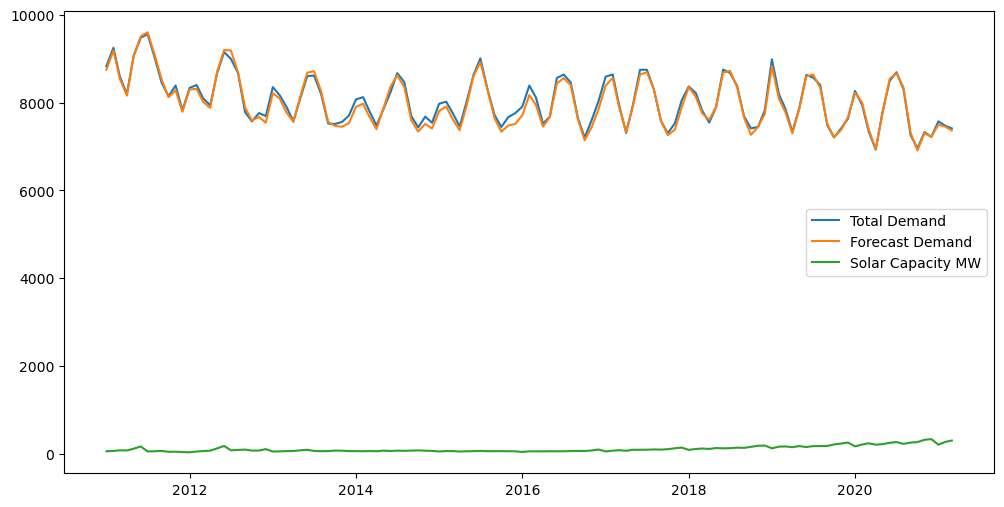

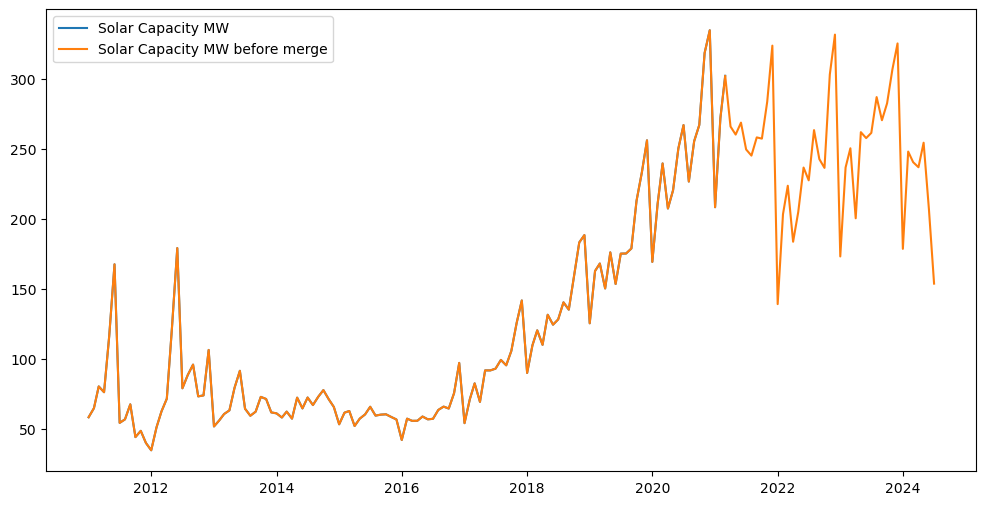

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
##$% from keras.models import Sequential
##$% from keras.layers import LSTM, Dense, Dropout, Input
##$% from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler

import matplotlib.dates as mdates

## 4 lines below replace ##$% above
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from keras.losses import Huber

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    model.add(Dropout(0.20))
    model.add(Dense(1, activation='linear'))
    
    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    ##model.compile(optimizer=optimizer, loss='mean_absolute_error')
    ##model.compile(optimizer=optimizer, loss='huber')
    return model

# Create a datetime index using the year and month columns
forecastdemand_nsw['date'] = pd.to_datetime(forecastdemand_nsw[['year', 'month']].assign(day=1))
forecastdemand_nsw.set_index('date', inplace=True)

# Resample the data to monthly frequency, using the mean for each month
monthly_forecast_demand = forecastdemand_nsw.resample('MS').mean(numeric_only=True)
print('monthly_forecast_demand.head')
print(monthly_forecast_demand.head())
print('monthly_forecast_demand.tail')
print(monthly_forecast_demand.tail())
print("Number of (rows, cols):", monthly_forecast_demand.shape)

# Create a datetime index using the year and month columns for solar_summary_cap_nsw
solar_summary_cap_nsw['date'] = pd.to_datetime(solar_summary_cap_nsw[['year', 'month']].assign(day=1))
solar_summary_cap_nsw.set_index('date', inplace=True)

# add Capaciyt MW column to solar_summary_cap_nsw
solar_summary_cap_nsw['Capacity MW'] = solar_summary_cap_nsw['Capacity kW'] / 1000
print('solar_summary_cap_nsw.head')
print(solar_summary_cap_nsw.head())
print('solar_summary_cap_nsw.tail')
print(solar_summary_cap_nsw.tail())
print("Number of (rows, cols):", solar_summary_cap_nsw.shape)

# Create a datetime index for monthly_totaldemand_nsw
monthly_totaldemand_nsw['date'] = pd.to_datetime(monthly_totaldemand_nsw[['year', 'month']].assign(day=1))
monthly_totaldemand_nsw.set_index('date', inplace=True)
print('monthly_totaldemand_nsw.head')
print(monthly_totaldemand_nsw.head())
print('monthly_totaldemand_nsw.tail')
print(monthly_totaldemand_nsw.tail())
print("Number of (rows, cols):", monthly_totaldemand_nsw.shape)

# Merge dataframes on the datetime index
merged_df = pd.merge(monthly_totaldemand_nsw, monthly_forecast_demand, left_index=True, right_index=True, how='left')
merged_df_withsolar = pd.merge(merged_df, solar_summary_cap_nsw, left_index=True, right_index=True, how='left')

merged_df_withsolar.dropna(inplace=True)
##print(merged_df_withsolar.head())

# Select only the necessary columns for the model
columns_to_keep = ['TOTALDEMAND', 'FORECASTDEMAND', 'Capacity MW']#, 'Capacity kW']
cleaned_df = merged_df_withsolar[columns_to_keep]
print('cleaned_df.head')
print(cleaned_df.head())
print('cleaned_df.tail')
print(cleaned_df.tail())
print("Number of (rows, cols):", cleaned_df.shape)

## plot data to see if any outliers or anomalies
plt.figure(figsize=(12, 6))
plt.plot(merged_df_withsolar['TOTALDEMAND'], label='Total Demand')
plt.plot(merged_df_withsolar['FORECASTDEMAND'], label='Forecast Demand')
plt.plot(merged_df_withsolar['Capacity MW'], label='Solar Capacity MW')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(merged_df_withsolar['Capacity MW'], label='Solar Capacity MW')
plt.plot(solar_summary_cap_nsw['Capacity MW'], label='Solar Capacity MW before merge')
plt.legend()
plt.show()

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.1183 - val_loss: 0.0475
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0416 - val_loss: 0.0374
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0221 - val_loss: 0.0407
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0334 - val_loss: 0.0482
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0384 - val_loss: 0.0437
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0357 - val_loss: 0.0264
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0227 - val_loss: 0.0183
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0219 - val_loss: 0.0564
Epoch 9/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0171 - val_loss: 0.0202
Epoch 10/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0115 - val_loss: 0.0376
Epoch 11/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0174 - val_loss: 0.0165
Epoch 12/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0083 - val_loss: 0.0236
Epoch 36/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0102 - val_loss: 0.0239
Epoch 37/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0091 - val_loss: 0.0264
Epoch 38/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0058 - val_loss: 0.0165
Epoch 39/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0056 - val_loss: 0.0223
Epoch 40/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0059 - val_loss: 0.0170
Epoch 41/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0077 - val_loss: 0.0179
Epoch 42/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0048 - val_loss: 0.0185
Epoch 43/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0052 - val_loss: 0.1001
Epoch 44/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0279 - val_loss: 0.0454
Epoch 45/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0289 - val_loss: 0.0476
Epoch 46/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - l

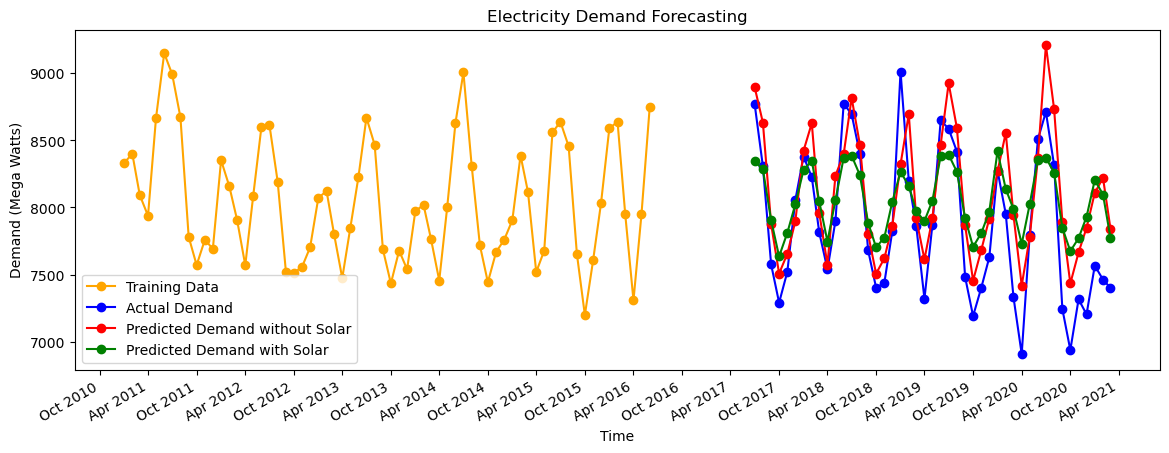

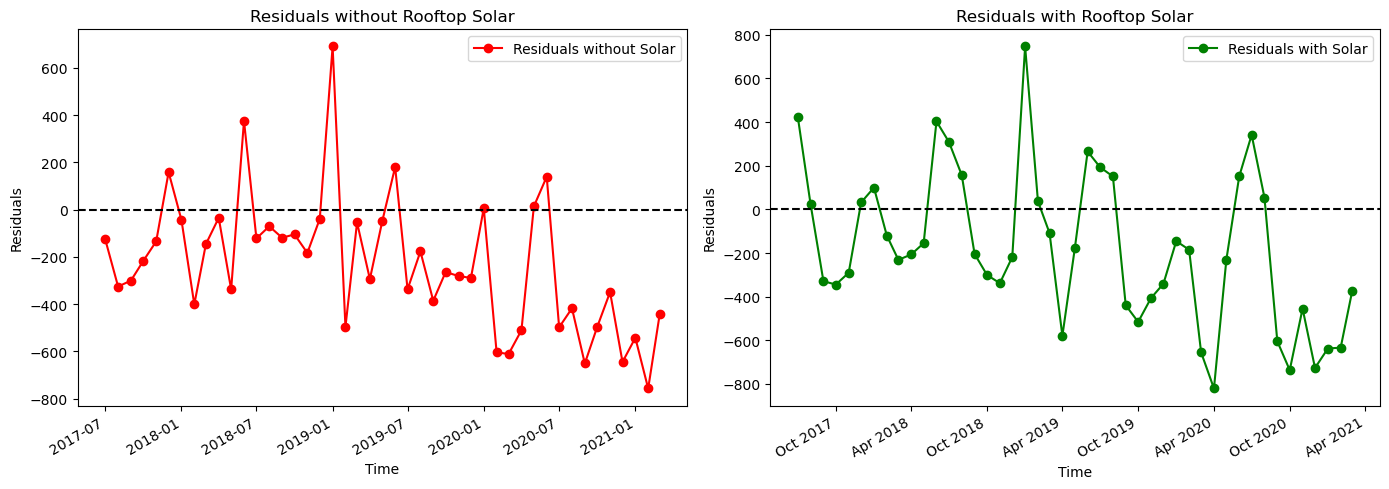

In [24]:
# Keep the date column for plotting
date_column = cleaned_df.index

def preprocess_data(df, feature_col, target_col, time_steps=1):
    data = df[[feature_col, target_col]].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    X, y = [], []
    for i in range(len(scaled_data) - time_steps):
        ##X.append(scaled_data[i:(i + time_steps), 0])
        ##y.append(scaled_data[i + time_steps, 1])
        X.append(scaled_data[i:(i + time_steps), :-1])
        y.append(scaled_data[i + time_steps, -1])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

feature_cols = ['TOTALDEMAND', 'FORECASTDEMAND', 'Capacity MW']
target_col = 'TOTALDEMAND'

# Preprocess data
time_steps = 12 #12  # Adjust as needed
X, y, scaler = preprocess_data(cleaned_df, 'FORECASTDEMAND', 'TOTALDEMAND', time_steps)

# Split data into training and testing sets
split = int(0.6 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Create and train the model
model = create_lstm_model((X_train.shape[1], 1))
model.fit(X_train, y_train, epochs=100, batch_size=1, validation_data=(X_test, y_test))

# Evaluate the model
def evaluate_model(model, X_test, y_test, scaler):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], 1))), axis=1))[:, 0]
    y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))), axis=1))[:, 0]
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    return rmse, predictions, y_test

# Evaluate without rooftop solar data
rmse_without_solar, predictions_without_solar, y_test_without_solar = evaluate_model(model, X_test, y_test, scaler)

# Incorporate rooftop solar data into the model
cleaned_df = cleaned_df.copy()  # Ensure we are working with a copy to avoid SettingWithCopyWarning
cleaned_df.loc[:, 'total_demand_with_solar'] = cleaned_df['TOTALDEMAND'] - cleaned_df['Capacity MW'] #MW']
X_with_solar, y_with_solar, scaler_with_solar = preprocess_data(cleaned_df, 'FORECASTDEMAND', 'total_demand_with_solar', time_steps)

# Split data into training and testing sets
X_train_with_solar, X_test_with_solar = X_with_solar[:split], X_with_solar[split:]
y_train_with_solar, y_test_with_solar = y_with_solar[:split], y_with_solar[split:]

# Create and train the model with solar data
model_with_solar = create_lstm_model((X_train_with_solar.shape[1], 1))
model_with_solar.fit(X_train_with_solar, y_train_with_solar, epochs=100, batch_size=1, validation_data=(X_test_with_solar, y_test_with_solar))

# Evaluate with rooftop solar data
rmse_with_solar, predictions_with_solar, y_test_with_solar = evaluate_model(model_with_solar, X_test_with_solar, y_test_with_solar, scaler_with_solar)
print(f'RMSE without rooftop solar: {rmse_without_solar}')
print(f'RMSE with rooftop solar: {rmse_with_solar}')

# Inverse transform the training data and testing data for plotting
y_train_inverse = scaler.inverse_transform(np.concatenate((np.zeros((y_train.shape[0], 1)), y_train.reshape(-1 ,1)), axis=1))[:, 1]
###y_test_inverse = scaler.inverse_transform(np.concatenate((np.zeros((y_test.shape[0], 1)), y_test.reshape(-1 ,1)), axis=1))[:, 1]

# Ensure y_test_inverse and y_test_with_solar are correctly defined
y_test_inverse = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))), axis=1))[:, 0]
y_test_with_solar_inverse = scaler_with_solar.inverse_transform(np.concatenate((y_test_with_solar.reshape(-1, 1), np.zeros((y_test_with_solar.shape[0], 1))), axis=1))[:, 0]

# Calculate R-squared value for predictions without solar
r2_without_solar = r2_score(y_test_inverse, predictions_without_solar)

# Calculate R-squared value for predictions with solar
r2_with_solar = r2_score(y_test_with_solar, predictions_with_solar)
print(f'R-squared value without rooftop solar: {r2_without_solar}')
print(f'R-squared value with rooftop solar: {r2_with_solar}')

# Plot results with training data included
plt.figure(figsize=(14, 5))

# Use the date column for the x-axis
plt.plot(date_column[:len(y_train)], y_train_inverse, color='orange', marker='o', label='Training Data')
plt.plot(date_column[-len(y_test_inverse):], y_test_inverse, color='blue', marker='o', label='Actual Demand')
plt.plot(date_column[-len(predictions_without_solar):], predictions_without_solar, color='red', marker='o', label='Predicted Demand without Solar')
plt.plot(date_column[-len(predictions_with_solar):], predictions_with_solar, color='green', marker='o', label='Predicted Demand with Solar')

# Format x-axis to show every 6th month correctly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.title('Electricity Demand Forecasting')
plt.xlabel('Time')
plt.ylabel('Demand (Mega Watts)')
#plt.legend()
plt.legend(loc='lower left')
plt.gcf().autofmt_xdate()  # Rotate date labels
plt.show()

#### plot the residuals for your model:
# Calculate residuals
residuals_without_solar = y_test_inverse - predictions_without_solar
##residuals_with_solar = y_test_with_solar_inverse - predictions_with_solar
residuals_with_solar = y_test_inverse- predictions_with_solar

# Plot residuals
plt.figure(figsize=(14, 5))

# Residuals without rooftop solar
plt.subplot(1, 2, 1)
plt.plot(merged_df_withsolar.index[-len(residuals_without_solar):], residuals_without_solar, color='red', marker='o', label='Residuals without Solar')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals without Rooftop Solar')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()

# Residuals with rooftop solar
plt.subplot(1, 2, 2)
plt.plot(merged_df_withsolar.index[-len(residuals_with_solar):], residuals_with_solar, color='green', marker='o', label='Residuals with Solar')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals with Rooftop Solar')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()

# Format x-axis to show every 6th month correctly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.gcf().autofmt_xdate()  # Rotate date labels
plt.tight_layout()
plt.show()

# Best LSTM model correclty comparing with and without Solar data

## Compare 2 LSTM models include forecast and residual plots
1. one that takes BOTH TOTALDEMAND and Solar Capacity to predict future Demand<br>
2. Another takes only TOTALDEMAND to predict future demand<br>
RMSE with Solar Capacity: 350.5375260125245<br>
RMSE without Solar Capacity: 324.754776234881<br>
R-squared value with Solar Capacity as input: 0.5960609819926866<br>
R-squared value without Solar Capacity as input: 0.6532967881112441<br>

But only with some Hyperparameters, other choies of hyper parameters give differernt RMSe and Rsquared values<br>

**Long Short Term Memory is a Recurrent Neural Network**
One of the most advanced models out there to forecast time series is the Long Short-Term Memory (LSTM) Neural Network. According to Korstanje in his book, *Advanced Forecasting with Python*:
RoofTop solar capacity is actually subtracted from Actual Demand data and fed into the LSTM model
The ideal ranges for loss and validation loss (val_loss) can vary depending on the specific problem and dataset, but here are some general guidelines:

1. **Training Loss (loss)**:
   - **Low Values**: A lower training loss indicates that the model is fitting the training data well. However, if the training loss is too low, it might suggest overfitting, where the model learns the noise in the training data rather than the underlying pattern.
   - **Typical Range**: For many problems, a training loss value between 0.01 and 0.1 is considered good, but this can vary widely.

2. **Validation Loss (val_loss)**:
   - **Close to Training Loss**: Ideally, the validation loss should be close to the training loss. If the validation loss is significantly higher than the training loss, it might indicate overfitting.
   - **Stable Values**: The validation loss should decrease and stabilize over epochs. If it starts increasing while the training loss continues to decrease, it might be a sign of overfitting¹².

3. **Good Fit**:
   - **Both Decreasing and Stabilizing**: A good fit is indicated when both training and validation losses decrease and stabilize at a low value. This suggests that the model is learning the underlying patterns in the data without overfitting².

It's important to monitor these metrics and adjust your model accordingly. Techniques like early stopping, regularization, and cross-validation can help in achieving a good balance between training and validation loss.

Source: various <br>
(1) How to Diagnose Overfitting and Underfitting of LSTM Models. https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/.<br>
(2) Training and Validation Loss in Deep Learning - Baeldung. https://www.baeldung.com/cs/training-validation-loss-deep-learning.<br>
(3) How to Choose Loss Functions When Training Deep Learning Neural .... https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/.<br>
(4) How to Avoid Exploding Gradients With Gradient Clipping. https://machinelearningmastery.com/how-to-avoid-exploding-gradients-in-neural-networks-with-gradient-clipping/.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
Validation RMSE scores with Capacity MW: [0.10636676536205036, 0.06400950428979253, 0.07015744352107628, 0.09347202209021191, 0.07878596796348324]
Mean Validation RMSE with Capacity MW: 0.08255834064532286
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
Validation RMSE scores without Capacity MW: [0.10202127872513805, 0.07674450592964938, 0.07909877865276475, 0.11415157291327087, 0.1155026873370347]
Mean Validation RMSE without Capacity MW: 0.09750376471157156
Epoch 1/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.1691 - val_loss: 0.0934 - learning_rate: 0.0050
Epoch 2/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0390 - val_loss: 0.0429 - l

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0056 - val_loss: 0.0132 - learning_rate: 0.0032
Epoch 51/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0036 - val_loss: 0.0100 - learning_rate: 0.0032
Epoch 52/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0067 - val_loss: 0.0117 - learning_rate: 0.0032
Epoch 53/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0035 - val_loss: 0.0114 - learning_rate: 0.0032
Epoch 54/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0029 - val_loss: 0.0125 - learning_rate: 0.0032
Epoch 55/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0037 - val_loss: 0.0134 - learning_rate: 0.0032
Epoch 56/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0043 - val_loss: 0.0177 - learning_rate: 0.0032
Epoch 57/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0034 - val_loss: 0.0117 - learning_rate: 0.0032
Epoch 58/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0059 - val_loss: 0.0104 - learning_rate: 0.0032
Epoch 59/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0096 - val_loss: 0.0191 - learning_rate: 0.0040
Epoch 28/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0087 - val_loss: 0.0134 - learning_rate: 0.0040
Epoch 29/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0076 - val_loss: 0.0148 - learning_rate: 0.0040
Epoch 30/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0071 - val_loss: 0.0120 - learning_rate: 0.0040
Epoch 31/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0057 - val_loss: 0.0112 - learning_rate: 0.0040
Epoch 32/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0051 - val_loss: 0.0135 - learning_rate: 0.0040
Epoch 33/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0060 - val_loss: 0.0109 - learning_rate: 0.0040
Epoch 34/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0113 - val_loss: 0.0132 - learning_rate: 0.0040
Epoch 35/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0095 - val_loss: 0.0172 - learning_rate: 0.0040
Epoch 36/80
14/14 ━━━━

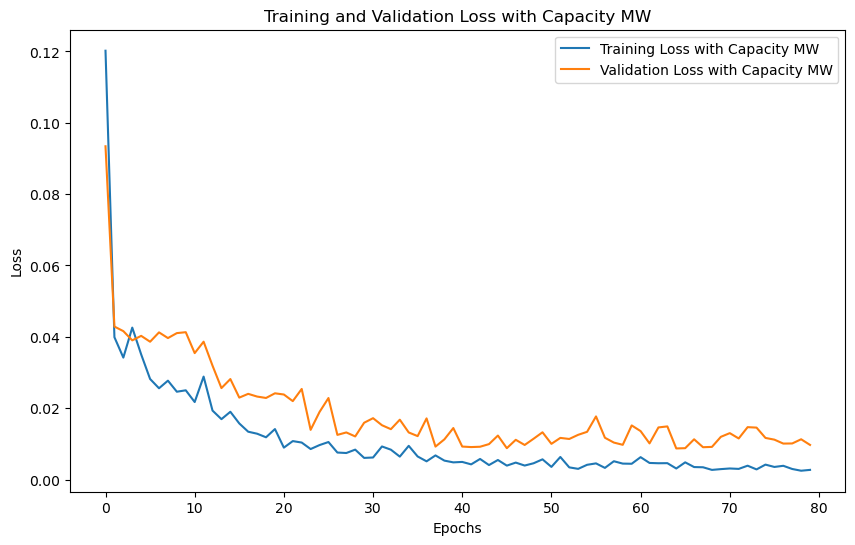

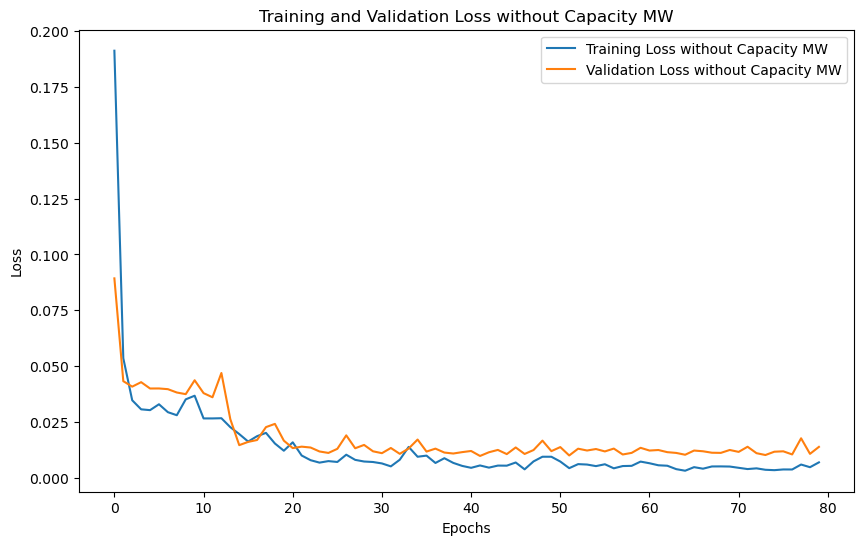

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
RMSE with Solar Capacity: 265.2737274220416
RMSE without Solar Capacity: 318.15964979311156
R-squared value with Solar Capacity as input: 0.7647040862159433
R-squared value without Solar Capacity as input: 0.6615331766201199
MAE with Solar Capacity: 195.98200366945088
MAPE with Solar Capacity: 2.5025077811733616
MAE without Solar Capacity: 244.1500151067093
MAPE without Solar Capacity: 3.095144442662891
Paired t-test: t-statistic = 2.1934252655021385, p-value = 0.032522066877009925
Wilcoxon signed-rank test: statistic = 631.0, p-value = 0.1731243326988916


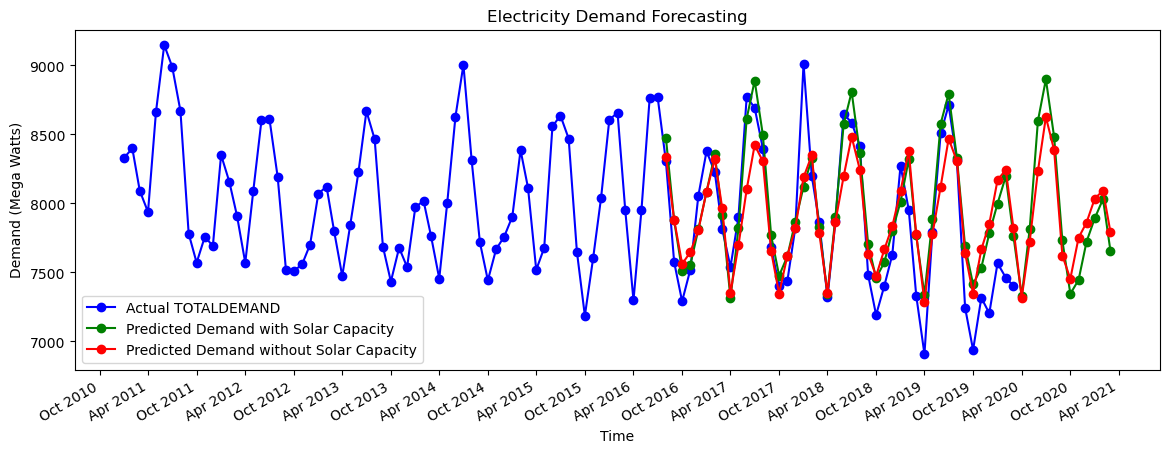

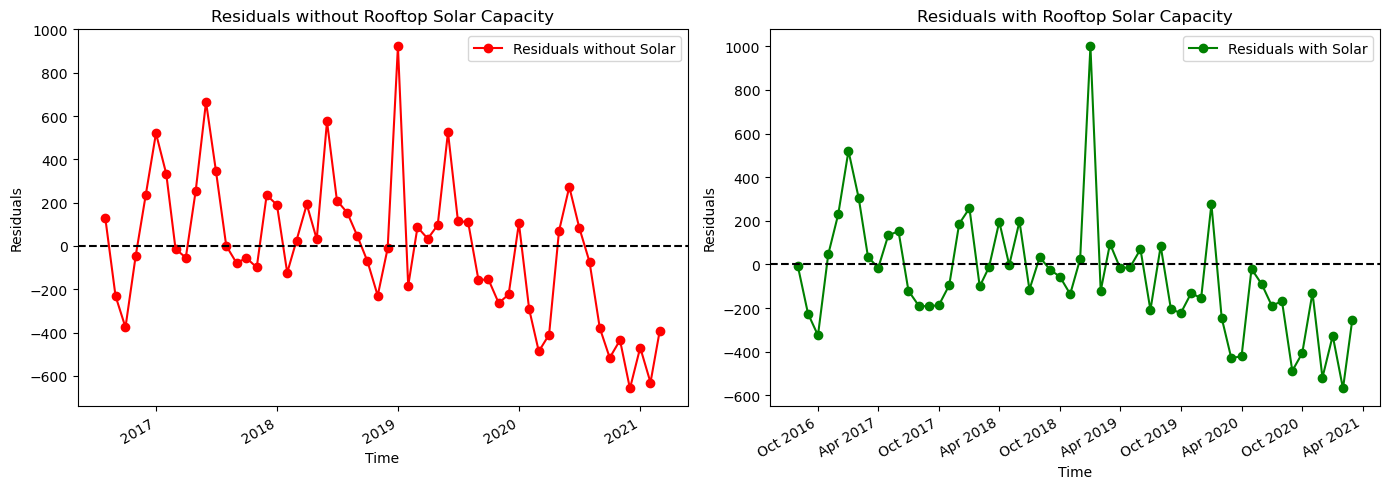

In [15]:
##########################################################################
#   MAKE SURE all Dfs have same set of mmm-yyyy  exact same date ranges
##########################################################################
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel, wilcoxon
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_error
##from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from keras.regularizers import l2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam

# Calculate additional metrics
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=140, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=140))#, kernel_regularizer=l2(0.001)))
    ##model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
      
    optimizer = Adam(learning_rate=0.005) #0.005
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define learning rate schedule function
def lr_schedule(epoch, lr):
    decay_rate = 0.8
    decay_step = 20
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

# Create learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Create a datetime index using the year and month columns
forecastdemand_nsw['date'] = pd.to_datetime(forecastdemand_nsw[['year', 'month']].assign(day=1))
forecastdemand_nsw.set_index('date', inplace=True)

# Resample the data to monthly frequency, using the mean for each month
monthly_forecast_demand = forecastdemand_nsw.resample('MS').mean(numeric_only=True)

# Create a datetime index using the year and month columns for solar_summary_cap_nsw
solar_summary_cap_nsw['date'] = pd.to_datetime(solar_summary_cap_nsw[['year', 'month']].assign(day=1))
solar_summary_cap_nsw.set_index('date', inplace=True)

# Add Capacity MW column to solar_summary_cap_nsw
solar_summary_cap_nsw['Capacity MW'] = solar_summary_cap_nsw['Capacity kW'] / 1000

# Create a datetime index for monthly_totaldemand_nsw
monthly_totaldemand_nsw['date'] = pd.to_datetime(monthly_totaldemand_nsw[['year', 'month']].assign(day=1))
monthly_totaldemand_nsw.set_index('date', inplace=True)

# Merge dataframes on the datetime index
merged_df = pd.merge(monthly_totaldemand_nsw, monthly_forecast_demand, left_index=True, right_index=True, how='left')
merged_df_withsolar = pd.merge(merged_df, solar_summary_cap_nsw, left_index=True, right_index=True, how='left')
## consider add the yearly solar voles
merged_df_withsolar.dropna(inplace=True)  ## remove NaNs 

# Select only the necessary columns for the model
columns_to_keep = ['TOTALDEMAND', 'FORECASTDEMAND', 'Capacity MW', 'year', 'month']
##columns_to_keep = ['TOTALDEMAND', 'FORECASTDEMAND', 'Capacity MW']
cleaned_df = merged_df_withsolar[columns_to_keep]

# Keep the date column for plotting
date_column = cleaned_df.index

def preprocess_data(df, feature_cols, target_col, time_steps=1):
    data = df[feature_cols + [target_col]].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    X, y = [], []
    for i in range(len(scaled_data) - time_steps):
        X.append(scaled_data[i:(i + time_steps), :-1])
        y.append(scaled_data[i + time_steps, -1])
    X, y = np.array(X), np.array(y)
    return X, y, scaler

########### Add Cros vaidation #####
def cross_validate_lstm(X, y, n_splits=5, epochs=50, batch_size=4):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    val_scores = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[lr_scheduler], verbose=0)
        val_predictions = model.predict(X_val)

        val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
        val_scores.append(val_rmse)
    return val_scores
########### Add Cros vaidation #####

# Preprocess data with 'Capacity MW'
time_steps = 12 #12 #6  # Adjust as needed
X_with_capacity, y_with_capacity, scaler_with_capacity = preprocess_data(cleaned_df, ['FORECASTDEMAND', 'TOTALDEMAND','Capacity MW', 'year', 'month'], 'TOTALDEMAND', time_steps)

###### 5-fold cross validation ###
val_scores_with_capacity = cross_validate_lstm(X_with_capacity, y_with_capacity, n_splits=5, epochs=90, batch_size=4)
##val_scores_with_capacity = cross_validate_lstm(X_with_capacity.shape[1], y_with_capacity.shape[2], n_splits=5, epochs=90, batch_size=3)
print(f'Validation RMSE scores with Capacity MW: {val_scores_with_capacity}')
print(f'Mean Validation RMSE with Capacity MW: {np.mean(val_scores_with_capacity)}')

# Preprocess data without 'Capacity MW'
X_without_capacity, y_without_capacity, scaler_without_capacity = preprocess_data(cleaned_df[['FORECASTDEMAND', 'TOTALDEMAND', 'year', 'month']], ['FORECASTDEMAND'], 'TOTALDEMAND', time_steps)

###### 5-fold cross validation ###
val_scores_without_capacity = cross_validate_lstm(X_without_capacity, y_without_capacity, n_splits=5, epochs=90, batch_size=3)
print(f'Validation RMSE scores without Capacity MW: {val_scores_without_capacity}')
print(f'Mean Validation RMSE without Capacity MW: {np.mean(val_scores_without_capacity)}')

# Split data into training and testing sets
split_with_capacity = int(0.5 * len(X_with_capacity))
X_train_with_capacity, X_test_with_capacity = X_with_capacity[:split_with_capacity], X_with_capacity[split_with_capacity:]
y_train_with_capacity, y_test_with_capacity = y_with_capacity[:split_with_capacity], y_with_capacity[split_with_capacity:]

split_without_capacity = int(0.5 * len(X_without_capacity))
X_train_without_capacity, X_test_without_capacity = X_without_capacity[:split_without_capacity], X_without_capacity[split_without_capacity:]
y_train_without_capacity, y_test_without_capacity = y_without_capacity[:split_without_capacity], y_without_capacity[split_without_capacity:]

# Create and train the model with 'Capacity MW'
model_with_capacity = create_lstm_model((X_train_with_capacity.shape[1], X_train_with_capacity.shape[2]))
##model_with_capacity.fit(X_train_with_capacity, y_train_with_capacity, epochs=80, batch_size=6, validation_data=(X_test_with_capacity, y_test_with_capacity), callbacks=[lr_scheduler])

#model_with_capacity = create_lstm_model((X_train_with_capacity.shape, X_train_with_capacity.shape))
history_with_capacity = model_with_capacity.fit(X_train_with_capacity, y_train_with_capacity, epochs=80, batch_size=8, validation_data=(X_test_with_capacity, y_test_with_capacity), callbacks=[lr_scheduler])


# Create and train the model without 'Capacity MW'
model_without_capacity = create_lstm_model((X_train_without_capacity.shape[1], X_train_without_capacity.shape[2]))

###model_without_capacity.fit(X_train_without_capacity, y_train_without_capacity, epochs=80, batch_size=3, validation_data=(X_test_without_capacity, y_test_without_capacity), callbacks=[lr_scheduler])

##model_without_capacity = create_lstm_model((X_train_without_capacity.shape, X_train_without_capacity.shape))
history_without_capacity = model_without_capacity.fit(X_train_without_capacity, y_train_without_capacity, epochs=80, batch_size=4, validation_data=(X_test_without_capacity, y_test_without_capacity), callbacks=[lr_scheduler])

#######
# Plot training and validation loss for model with 'Capacity MW'
plt.figure(figsize=(10, 6))
plt.plot(history_with_capacity.history['loss'], label='Training Loss with Capacity MW')
plt.plot(history_with_capacity.history['val_loss'], label='Validation Loss with Capacity MW')
plt.title('Training and Validation Loss with Capacity MW')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation loss for model without 'Capacity MW'
plt.figure(figsize=(10, 6))
plt.plot(history_without_capacity.history['loss'], label='Training Loss without Capacity MW')
plt.plot(history_without_capacity.history['val_loss'], label='Validation Loss without Capacity MW')
plt.title('Training and Validation Loss without Capacity MW')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
#######

# Evaluate the models
def evaluate_model(model, X_test, y_test, scaler):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], X_test.shape[2]))), axis=1))[:, 0]
    y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2]))), axis=1))[:, 0]
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    return rmse, predictions, y_test

# Evaluate the model with 'Capacity MW'
##rmse_with_capacity, predictions_with_capacity, y_test_with_capacity = evaluate_model(model_with_capacity, X_test_with_capacity, y_test_with_capacity, scaler_with_capacity)
rmse_with_capacity, predictions_with_capacity, y_test_with_capacity = evaluate_model(model_with_capacity, X_test_with_capacity, y_test_with_capacity, scaler_with_capacity)
mae_with_capacity, mape_with_capacity = calculate_metrics(y_test_with_capacity, predictions_with_capacity)[1:]

# Evaluate the model without 'Capacity MW'
##rmse_without_capacity, predictions_without_capacity, y_test_without_capacity = evaluate_model(model_without_capacity, X_test_without_capacity, y_test_without_capacity, scaler_without_capacity)
rmse_without_capacity, predictions_without_capacity, y_test_without_capacity = evaluate_model(model_without_capacity, X_test_without_capacity, y_test_without_capacity, scaler_without_capacity)
mae_without_capacity, mape_without_capacity = calculate_metrics(y_test_without_capacity, predictions_without_capacity)[1:]

print(f'RMSE with Solar Capacity: {rmse_with_capacity}')
print(f'RMSE without Solar Capacity: {rmse_without_capacity}')

# Calculate R-squared values
r2_with_capacity = r2_score(y_test_with_capacity, predictions_with_capacity)
r2_without_capacity = r2_score(y_test_without_capacity, predictions_without_capacity)
print(f'R-squared value with Solar Capacity as input: {r2_with_capacity}')
print(f'R-squared value without Solar Capacity as input: {r2_without_capacity}')

######### Print additional metrics
print(f'MAE with Solar Capacity: {mae_with_capacity}')
print(f'MAPE with Solar Capacity: {mape_with_capacity}')
print(f'MAE without Solar Capacity: {mae_without_capacity}')
print(f'MAPE without Solar Capacity: {mape_without_capacity}')

# Perform paired t-test
t_stat, p_value = ttest_rel(predictions_with_capacity, predictions_without_capacity)
print(f'Paired t-test: t-statistic = {t_stat}, p-value = {p_value}')

# Perform Wilcoxon signed-rank test
w_stat, p_value_wilcoxon = wilcoxon(predictions_with_capacity, predictions_without_capacity)
print(f'Wilcoxon signed-rank test: statistic = {w_stat}, p-value = {p_value_wilcoxon}')

# Ensure the shape of the zeros array matches the expected shape for both scalers
zeros_array_with_cap = np.zeros((y_train_with_capacity.shape[0], scaler_with_capacity.n_features_in_))

# Inverse transform the training data for plotting
y_train_inverse_with_cap = scaler_with_capacity.inverse_transform(
    np.concatenate((zeros_array_with_cap[:, :-1], y_train_with_capacity.reshape(-1, 1)), axis=1))[:, -1] # Use -1 to select the last column

# Combine training and testing data for TOTALDEMAND
total_demand_continuous = np.concatenate((y_train_inverse_with_cap, y_test_with_capacity))

#####
# Plot results with training data included
plt.figure(figsize=(14, 5))

# Use the date column for the x-axis # Plot TOTALDEMAND data = y_test_with_capacityused in training
##plt.plot(date_column[:len(y_train_with_capacity)], y_train_inverse_with_cap, color='orange', marker='o', label='Training Data with Solar Capacity')
plt.plot(date_column[:len(total_demand_continuous)], total_demand_continuous, color='blue', marker='o', label='Actual TOTALDEMAND')
##plt.plot(date_column[-len(y_test_with_capacity):], y_test_with_capacity, color='purple', marker='o', label='Actual Demand')
plt.plot(date_column[-len(predictions_with_capacity):], predictions_with_capacity, color='green', marker='o', label='Predicted Demand with Solar Capacity')
plt.plot(date_column[-len(predictions_without_capacity):], predictions_without_capacity, color='red', marker='o', label='Predicted Demand without Solar Capacity')

# Format x-axis to show every 6th month correctly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.title('Electricity Demand Forecasting')
plt.xlabel('Time')
plt.ylabel('Demand (Mega Watts)')
plt.legend(loc='lower left')
plt.gcf().autofmt_xdate()  # Rotate date labels
plt.show()

#### plot the residuals for your model:
## Calculate residuals
residuals_with_solar = y_test_with_capacity - predictions_with_capacity
residuals_without_solar = y_test_without_capacity - predictions_without_capacity

# Plot residuals
plt.figure(figsize=(14, 5))

# Residuals without rooftop solar
plt.subplot(1, 2, 1)
plt.plot(merged_df_withsolar.index[-len(residuals_without_solar):], residuals_without_solar, color='red', marker='o', label='Residuals without Solar')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals without Rooftop Solar Capacity')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()

# Residuals with rooftop solar
plt.subplot(1, 2, 2)
plt.plot(merged_df_withsolar.index[-len(residuals_with_solar):], residuals_with_solar, color='green', marker='o', label='Residuals with Solar')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals with Rooftop Solar Capacity')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()

# Format x-axis to show every 6th month correctly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.gcf().autofmt_xdate()  # Rotate date labels
plt.tight_layout()
plt.show()


# Statistically significant differrent in prediction accuracy of 2 models

To determine if there is a statistically significant difference in the prediction accuracy of the two LSTM models, you can look at the p-values from the paired t-test and the Wilcoxon signed-rank test.

1. **Paired t-test**: This test compares the means of two related groups to determine if there is a statistically significant difference between them. 
   - **p-value**: If the p-value is less than 0.05 (commonly used threshold), it indicates that there is a statistically significant difference between the two models' predictions.

2. **Wilcoxon signed-rank test**: This is a non-parametric test used to compare two related samples. It is used when the data does not necessarily follow a normal distribution.
   - **p-value**: Similar to the paired t-test, a p-value less than 0.05 indicates a statistically significant difference between the two models' predictions.

In summary:
- **p-value < 0.05**: Statistically significant difference.
- **p-value ≥ 0.05**: No statistically significant difference.

These tests will help determine if the inclusion of "Capacity MW" in our model significantly improves the prediction accuracy compared to the model without it.

##RESULTS<br>
RMSE with Solar Capacity: 340.3779632186719<br>
RMSE without Solar Capacity: 300.8389339119149<br>
R-squared value with Solar Capacity as input: 0.6126096697933814<br>
R-squared value without Solar Capacity as input: 0.697382535951214<br>
MAE with Solar Capacity: 266.47457592584743<br>
MAPE with Solar Capacity: 3.419170769438203<br>
MAE without Solar Capacity: 224.1708631024915<br>
MAPE without Solar Capacity: 2.8516420511195295<br>
Paired t-test: t-statistic = -0.5171732412967648, p-value = 0.6071089487659176  **No statistical difference**<br>
Wilcoxon signed-rank test: statistic = 748.0, p-value = 0.683380703167618  **No statistical difference**<br>

# Best practice tuning LSTM

For an LSTM model with 120 data points of monthly electricity demand data that exhibits a strong seasonal pattern, here are some best practice hyperparameters to consider:

1. **Learning Rate**: Start with a learning rate around 0.001. You can adjust this based on the model's performance.

2. **Number of Layers and Units**: Use 1-2 LSTM layers with 50-100 units each. Too many layers or units can lead to overfitting, especially with a smaller dataset.

3. **Dropout Rate**: Apply a dropout rate between 0.2 and 0.5 to prevent overfitting.

4. **Batch Size**: A batch size of 1-32 is typically effective for time series data. Smaller batch sizes can help capture the nuances of the data better.

5. **Sequence Length**: Set the sequence length to capture at least one full seasonal cycle. For monthly data with a yearly seasonality, a sequence length of 12 is a good starting point.

6. **Epochs**: Train the model for 50-100 epochs, but use early stopping to halt training if the validation loss stops improving.

7. **Regularization**: Add L2 regularization with a small coefficient (e.g., 0.001) to the LSTM layers to penalize large weights.

8. **Activation Function**: Use the hyperbolic tangent (tanh) activation function for the LSTM layers and a linear activation function for the output layer.

These hyperparameters are a good starting point, but you may need to fine-tune them based on your specific dataset and model performance. Tools like Keras Tuner can help automate the hyperparameter optimization process.

Source: various
(1) How to Tune LSTM Hyperparameters with Keras for Time Series Forecasting. https://machinelearningmastery.com/tune-lstm-hyperparameters-keras-time-series-forecasting/.
(2) Doing Multivariate Time Series Forecasting with Recurrent Neural .... https://www.databricks.com/blog/2019/09/10/doing-multivariate-time-series-forecasting-with-recurrent-neural-networks.html.
(3) Hyperparameter Optimization: Foundations, Algorithms, Best Practices .... https://arxiv.org/abs/2107.05847.
(4) Hyperparameter tuning with Keras Tuner — The TensorFlow Blog. https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html.


120 months of actual electricity demand and solar capacity data are fed as inputs to an LSTM model to predict demand , the<br>
data is seasonal and also has a long term declining trend (the solar capacity data has a late long term increasing trend).<br>
The residuals are random about zero then fall belwo zero for the most recent 12 month of predicted values..,. how can i <br>
tune the model to perfrom betere and pick up both long term trends and seasonal trends?<br>
To improve your LSTM model's ability to capture both long-term trends and seasonal patterns in your electricity demand <br>
and solar capacity data, you can consider several strategies:<br>

### 1. **Feature Engineering**
- **Add Time-Based Features**: Include features like month, quarter, and year to help the model capture seasonality and long-term trends.
- **Lag Features**: Create lagged versions of your input features to provide the model with historical context.
- **Rolling Statistics**: Add rolling means, standard deviations, and other statistics to capture trends and seasonality.

### 2. **Model Architecture**
- **Stacked LSTM Layers**: Use multiple LSTM layers to capture more complex patterns. For example, you can stack two or three LSTM layers with `return_sequences=True` for all but the last layer.
- **Bidirectional LSTM**: Use bidirectional LSTM layers to capture patterns in both forward and backward directions.
- **Attention Mechanism**: Incorporate an attention mechanism to help the model focus on important parts of the input sequence.

### 3. **Hyperparameter Tuning**
- **Learning Rate**: Experiment with different learning rates. Sometimes a smaller learning rate can help the model learn more subtle patterns.
- **Batch Size**: Try different batch sizes. Smaller batch sizes can sometimes help the model generalize better.
- **Epochs**: Ensure you train for enough epochs but also use early stopping to prevent overfitting.

### 4. **Regularization**
- **Dropout**: Use dropout layers to prevent overfitting. You can experiment with different dropout rates.
- **L2 Regularization**: Apply L2 regularization to the LSTM layers to penalize large weights.

### 5. **Data Preprocessing**
- **Normalization**: Ensure your data is properly normalized. You might want to use different scalers for different features if they have different ranges.
- **Seasonal Decomposition**: Decompose your time series data into trend, seasonal, and residual components and use these components as separate features.

### 6. **Model Evaluation and Residual Analysis**
- **Residual Analysis**: Analyze the residuals to understand where the model is underperforming. If the residuals show a pattern, it indicates that the model is missing some information.
- **Cross-Validation**: Use time series cross-validation techniques like rolling or expanding window cross-validation to ensure your model is robust.


# Adding time-based features
cleaned_df['month'] = cleaned_df.index.month
cleaned_df['year'] = cleaned_df.index.year

# Preprocess data with additional features
X_with_capacity, y_with_capacity, scaler_with_capacity = preprocess_data(cleaned_df, ['FORECASTDEMAND', 'TOTALDEMAND', 'Capacity MW', 'month', 'year'], 'TOTALDEMAND', time_steps)


### Final Thoughts
